# **DATA CLEANING NOTEBOOK**

## Objectives

* Clean data
* Split data into Train and Test sets

## Inputs

* outputs/datasets/collection/house_prices_records.csv

## Outputs

* Cleaned Test and Train data
* Generated data saved under outputs/datasets/cleaned




---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing-issues'

# Load Data

In [4]:
import pandas as pd
df_raw_path = "outputs/datasets/collection/house_prices_records.csv"
df = pd.read_csv(df_raw_path)
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

# Explore Missing Data

Section 2 content

In [5]:
missing_data = df.columns[df.isna().sum() > 0].to_list()
missing_data

['2ndFlrSF',
 'BedroomAbvGr',
 'BsmtExposure',
 'BsmtFinType1',
 'EnclosedPorch',
 'GarageFinish',
 'GarageYrBlt',
 'LotFrontage',
 'MasVnrArea',
 'WoodDeckSF']

Install ydata-profiling and ipywidgets

In [6]:
# !pip install ydata-profiling
# !pip install ipywidgets

In [6]:
from ydata_profiling import ProfileReport
if missing_data:
    profile = ProfileReport(df=df[missing_data], minimal=True)
    profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
# # Convert columns to numeric, coercing errors to NaN
# df = df.apply(pd.to_numeric, errors='coerce')

In [8]:
# def EvaluateMissingData(df):
#     missing_data_absolute = df.isnull().sum()
#     missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
#     df_missing_data = (pd.DataFrame(
#         data={"RowsWithMissingData": missing_data_absolute,
#               "PercentageOfDataset": missing_data_percentage,
#               "DataType": df.dtypes}
#     )
#                        .sort_values(by=['PercentageOfDataset'], ascending=False)
#                        .query("PercentageOfDataset > 0")
#                       )
#     return df_missing_data
    

In [9]:
# EvaluateMissingData(df)

---

# Correlation and PPS

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps

In [11]:
def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

In [12]:
print(df.dtypes)

1stFlrSF           int64
2ndFlrSF         float64
BedroomAbvGr     float64
BsmtExposure      object
BsmtFinSF1         int64
BsmtFinType1      object
BsmtUnfSF          int64
EnclosedPorch    float64
GarageArea         int64
GarageFinish      object
GarageYrBlt      float64
GrLivArea          int64
KitchenQual       object
LotArea            int64
LotFrontage      float64
MasVnrArea       float64
OpenPorchSF        int64
OverallCond        int64
OverallQual        int64
TotalBsmtSF        int64
WoodDeckSF       float64
YearBuilt          int64
YearRemodAdd       int64
SalePrice          int64
dtype: object


In [13]:
non_numeric_cols = df.select_dtypes(include=['object']).columns
print("Non-numeric columns:", non_numeric_cols)


Non-numeric columns: Index(['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual'], dtype='object')


In [16]:
df[non_numeric_cols] = df[non_numeric_cols].apply(lambda x: pd.factorize(x)[0])


In [17]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.035  0.085  0.0  0.0  0.0  0.029  0.702


In [18]:
# print(df.head())  # Display the first few rows of the DataFrame
# print(df.dtypes)  # Display the data types of each column


In [19]:
# # Convert columns to numeric, coercing errors to NaN
# df = df.apply(pd.to_numeric, errors='coerce')


In [20]:
# df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

In [21]:
%matplotlib inline




* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



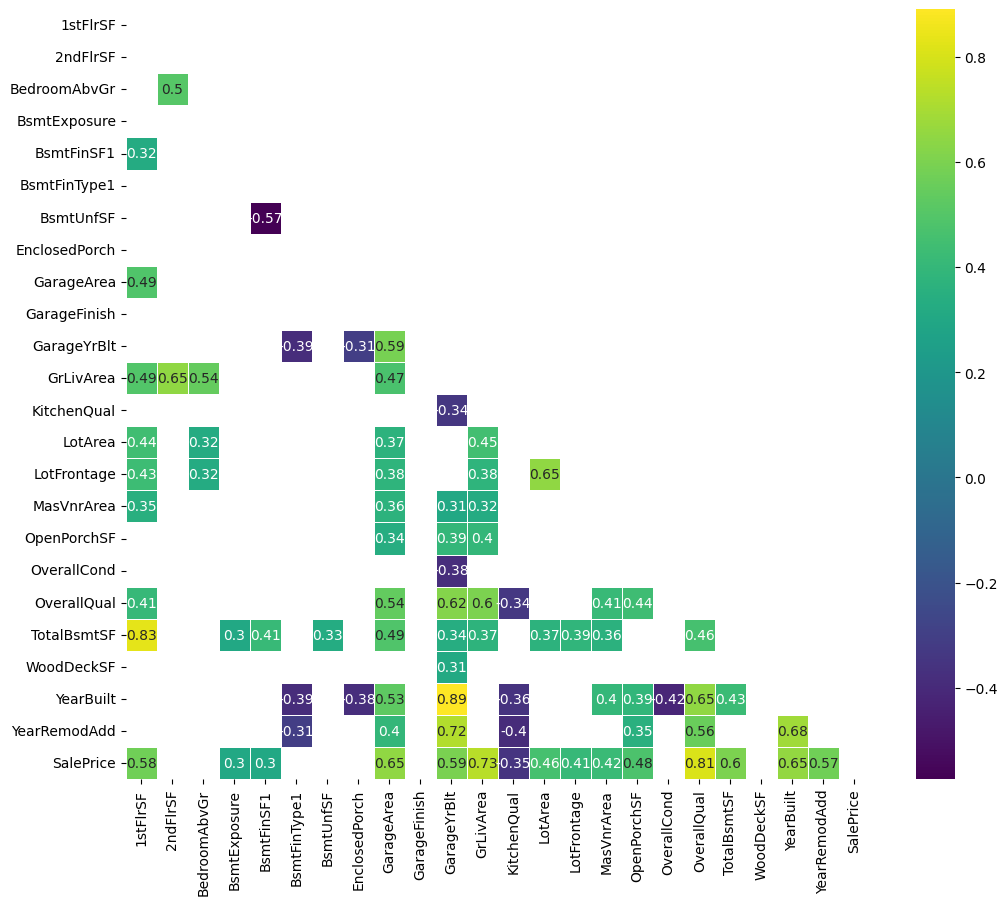



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



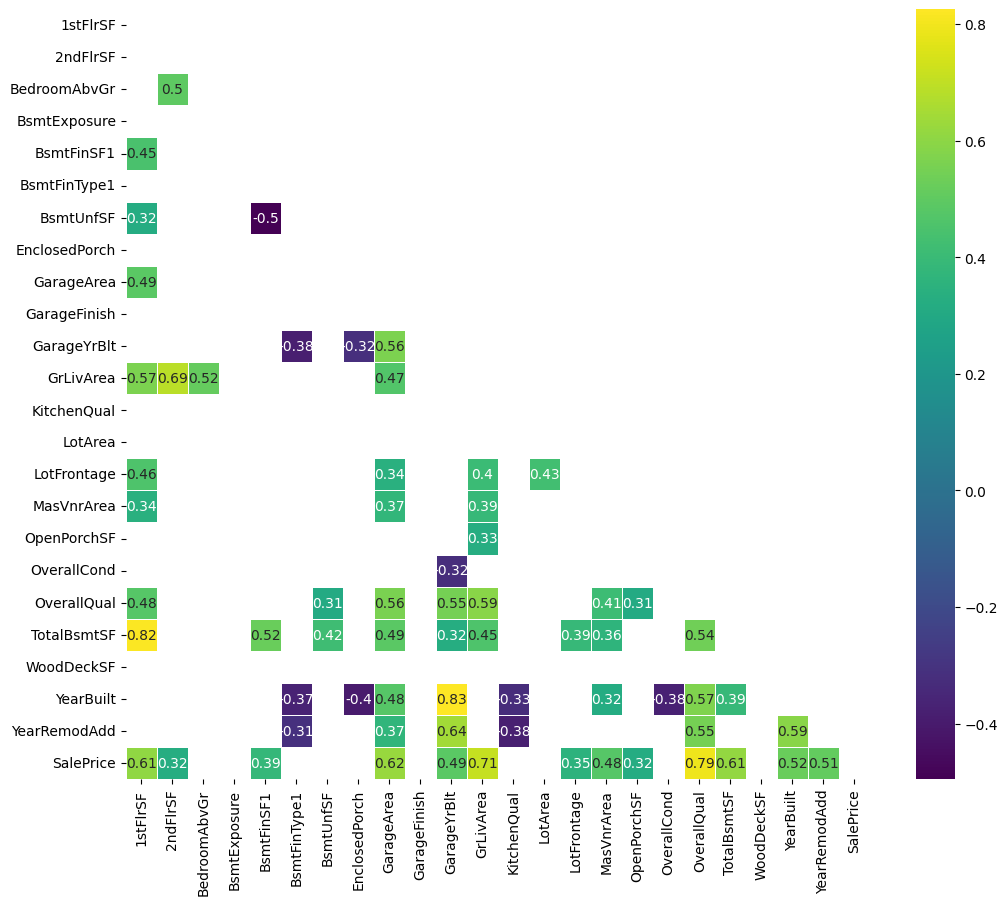



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



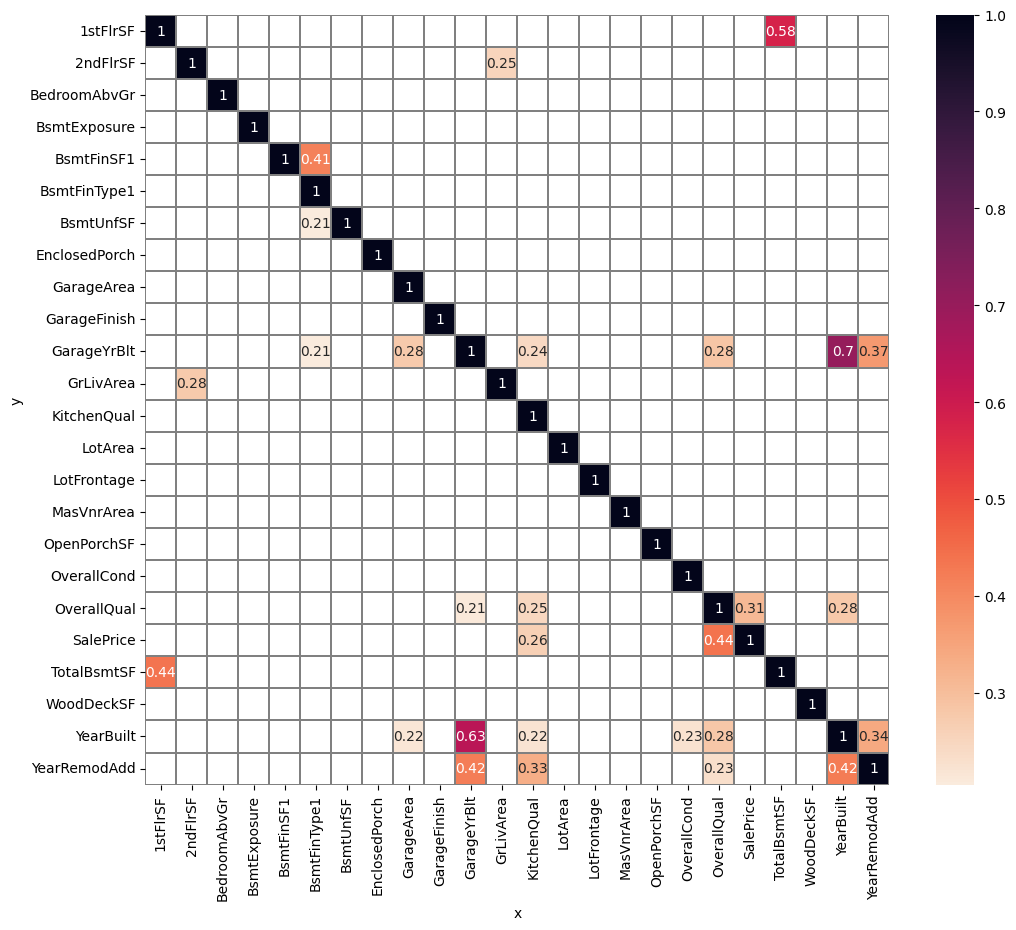

In [22]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman,
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.3, PPS_Threshold = 0.2,
                  figsize=(12,10), font_annot = 10)

# Data Cleaning

In [23]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data

In [24]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


# Split Train and Test Set

In [30]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


* Drop Variables - EnclosedPorch and WoodDeckSF

In [31]:
from feature_engine.selection import DropFeatures

variables_method = ['EnclosedPorch', 'WoodDeckSF']

imputer = DropFeatures(features_to_drop=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

* Arbitrary Number Imputation - 2ndFlrSF, MasVnrArea


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['MasVnrArea', '2ndFlrSF'] 




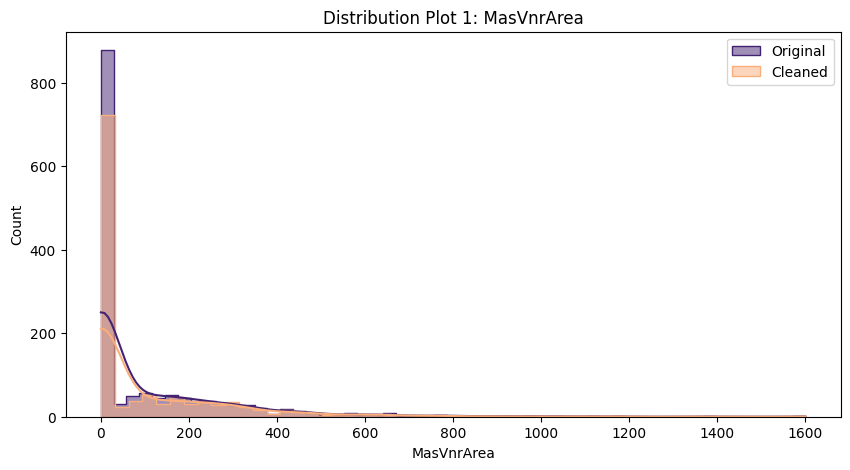

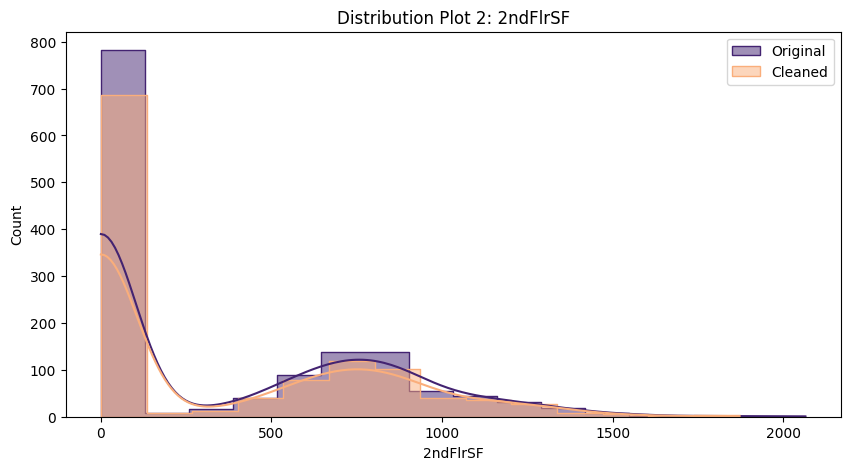

In [33]:
from feature_engine.imputation import  ArbitraryNumberImputer

variables_method = ['MasVnrArea', '2ndFlrSF']

imputer = ArbitraryNumberImputer(arbitrary_number=0, variables=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

DataCleaningEffect(df_original=df, df_cleaned=df_method, variables_applied_with_method=variables_method)

* Median Imputation - BedroomAbvGr, GarageYrBlt, and LotFrontage


* Distribution Effect Analysis After Data Cleaning Method in the following variables:
['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt'] 




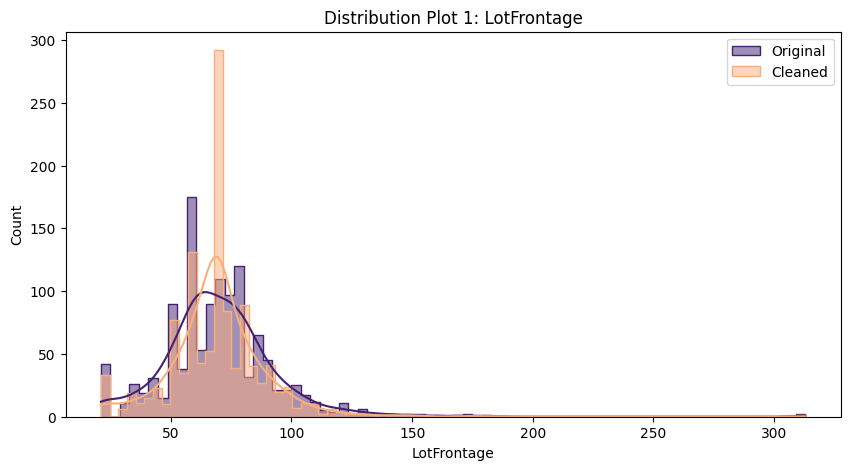

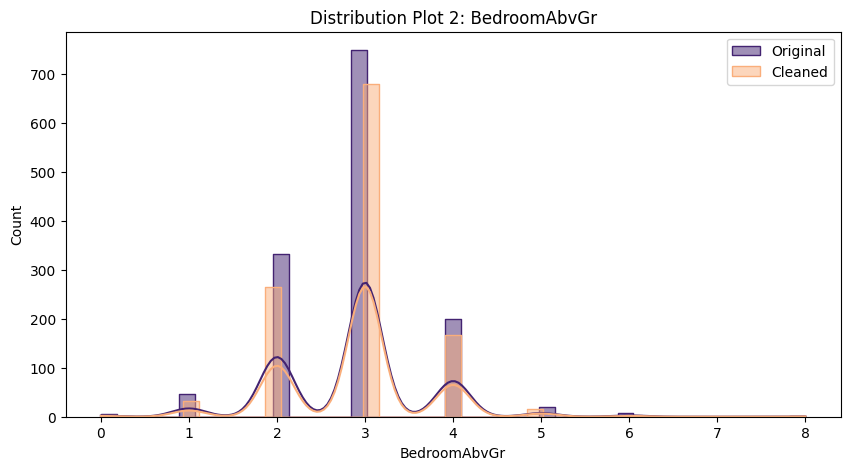

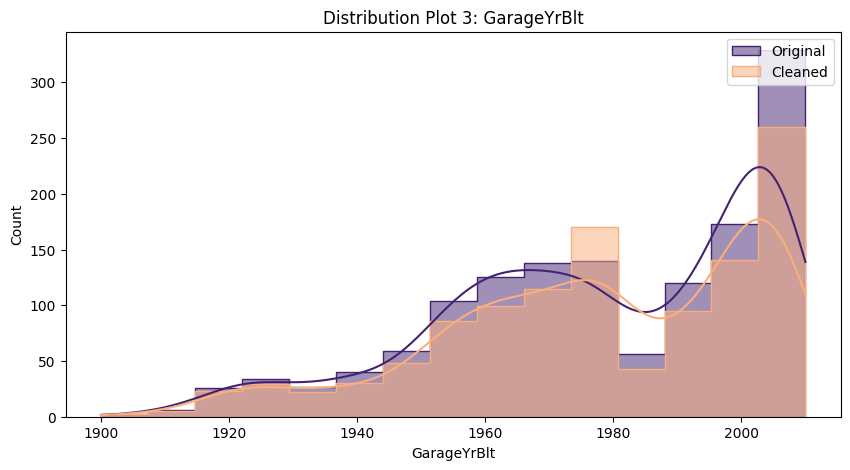

In [32]:
from feature_engine.imputation import  MeanMedianImputer

variables_method = ['LotFrontage', 'BedroomAbvGr', 'GarageYrBlt']

imputer = MeanMedianImputer(imputation_method='median', variables=variables_method)
imputer.fit(TrainSet)
df_method = imputer.transform(TrainSet)

TrainSet, TestSet = imputer.transform(TrainSet) , imputer.transform(TestSet)

DataCleaningEffect(df_original=df, df_cleaned=df_method, variables_applied_with_method=variables_method)

In [35]:
EvaluateMissingData(TrainSet)
EvaluateMissingData(TestSet)

,RowsWithMissingData,PercentageOfDataset,DataType


---

# Push files to Repo

In [36]:
import os
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)

## Save Train Set

In [37]:
TrainSet.to_csv("outputs/datasets/cleaned/TrainSetCleaned.csv", index=False)

## Save Test Set

In [38]:
TestSet.to_csv("outputs/datasets/cleaned/TestSetCleaned.csv", index=False)